# Hate Speech Detection on Twitter

---

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import random
import xgboost as xgb

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [13]:
original_data = pd.read_csv('dataset/re_dataset.csv', encoding="ISO-8859-1")
original_data.columns = original_data.columns.str.lower()
original_data.head(5)

,tweet,hs,abusive,hs_individual,hs_group,hs_religion,hs_race,hs_physical,hs_gender,hs_other,hs_weak,hs_moderate,hs_strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [14]:
for i in original_data.tweet[:5].values:
    print(i, '\n')

- disaat semua cowok berusaha melacak perhatian gue. loe lantas remehkan perhatian yg gue kasih khusus ke elo. basic elo cowok bego ! ! !' 

RT USER: USER siapa yang telat ngasih tau elu?edan sarap gue bergaul dengan cigax jifla calis sama siapa noh licew juga' 

41. Kadang aku berfikir, kenapa aku tetap percaya pada Tuhan padahal aku selalu jatuh berkali-kali. Kadang aku merasa Tuhan itu ninggalkan aku sendirian. Ketika orangtuaku berencana berpisah, ketika kakakku lebih memilih jadi Kristen. Ketika aku anak ter 

USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT TAPI DILIAT DARI MANA ITU AKU' 

USER USER Kaum cebong kapir udah keliatan dongoknya dari awal tambah dongok lagi hahahah' 



---

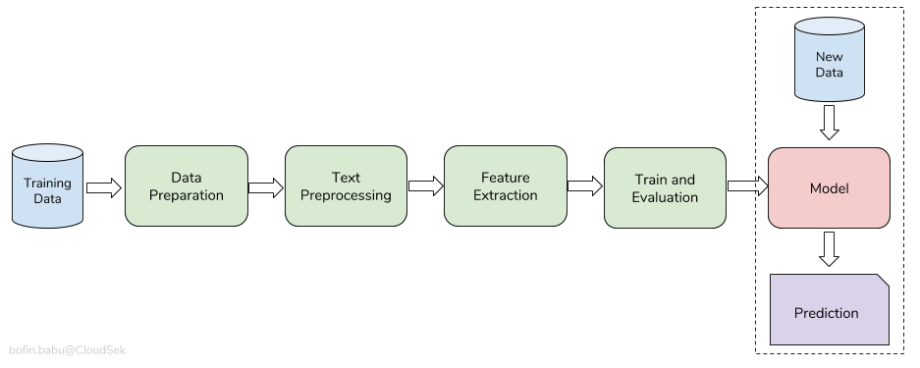

source: https://cloudsek.com/wp-content/uploads/2019/12/text-classification-workflow-920x368.png

---

# 1. Data Preprocessing

### 1.1 Data Preprocessing - Case Folding

In [15]:
data = original_data.copy()
data.tweet = data.tweet.str.lower()

In [16]:
data.head(5)

,tweet,hs,abusive,hs_individual,hs_group,hs_religion,hs_race,hs_physical,hs_gender,hs_other,hs_weak,hs_moderate,hs_strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,rt user: user siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,user user aku itu aku\n\nku tau matamu sipit t...,0,0,0,0,0,0,0,0,0,0,0,0
4,user user kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


### 1.2 Data Preprocessing - Data Cleaning
- username -> USER (already converted)
- link -> URL (already converted)

`https://www.kaggle.com/redwankarimsony/nlp-101-tweet-sentiment-analysis-preprocessing`

In [17]:
# retweet symbol (RT) -> remove

def remove_rt(s):
    return re.sub(r'^rt[\s]+', '', s)

data.tweet = data.tweet.apply(lambda x: remove_rt(x))

In [18]:
string = "rt user: user siapa yang telat ngasih tau elu?"

print(string)
remove_rt(string)

rt user: user siapa yang telat ngasih tau elu?


'user: user siapa yang telat ngasih tau elu?'

In [19]:
# hashtag -> remove

def remove_hashtag(s):
    return re.sub(r'#[\w\d]+', ' hashtag ', s)

data.tweet = data.tweet.apply(lambda x: remove_hashtag(x))

In [20]:
string = "USER USER masa baru kena hestek aja udah kepanasan ??? Kepo banget ; ; #2019GantiPresiden"

print(string)
remove_hashtag(string)

USER USER masa baru kena hestek aja udah kepanasan ??? Kepo banget ; ; #2019GantiPresiden


'USER USER masa baru kena hestek aja udah kepanasan ??? Kepo banget ; ;  hashtag '

In [21]:
# remove linebreak, example: \n

def remove_linebreak(s):
    return re.sub(r'\\n{1}', ' ', s)

data.tweet = data.tweet.apply(lambda x: remove_linebreak(x))

In [22]:
# remove emoji, example: \xf0

def remove_emoji(s):
    return re.sub(r'\\[\w\d]{3}', ' ', s)

data.tweet = data.tweet.apply(lambda x: remove_emoji(x))

In [23]:
# remove https/http

def remove_http(s):
    return re.sub(r'http:[^\s]+|https:[^\s]+', ' ', s)

data.tweet = data.tweet.apply(lambda x: remove_http(x))

In [24]:
# numbers -> number

def remove_number(s):
    return re.sub(r'\d+', ' number ', s)

data.tweet = data.tweet.apply(lambda x: remove_number(x))

In [25]:
# remove &amp;, means "An ampersand" (& symbol)

def remove_ampersand(s):
    return re.sub(r'&amp;', ' ', s)

data.tweet = data.tweet.apply(lambda x: remove_ampersand(x))

In [26]:
# punctuation -> remove

def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', ' ', (word))
        if new_word != '':
            new_words.append(new_word)
    no_punc = ''.join(new_words).replace('  ', ' ')
    return no_punc

data.tweet = data.tweet.apply(lambda x: remove_punctuation(x))

In [27]:
# remove 2 or more spaces 

def remove_spaces(s):
    return re.sub(r'\s{2,}', ' ', s)

data.tweet = data.tweet.apply(lambda x: remove_spaces(x))

### 1.3 Data Preprocessing - Text Normalization

using `new_kamusalay.csv` to convert non-formal into formal words

In [28]:
kamus = pd.read_csv('dataset/new_kamusalay.csv', encoding="ISO-8859-1", names=['nonformal', 'formal'])
kamus.sample(5)

,nonformal,formal
9844,nmasa2,masa masa
12436,disiniÃ°,di sini
13212,encan,kencan
13240,eue,ngewe
12165,dibelakang,di belakang


In [29]:
normalized = data.copy()
normalized

,tweet,hs,abusive,hs_individual,hs_group,hs_religion,hs_race,hs_physical,hs_gender,hs_other,hs_weak,hs_moderate,hs_strong
0,disaat semua cowok berusaha melacak perhatian...,1,1,1,0,0,0,0,0,1,1,0,0
1,user user siapa yang telat ngasih tau elu edan...,0,1,0,0,0,0,0,0,0,0,0,0
2,number kadang aku berfikir kenapa aku tetap p...,0,0,0,0,0,0,0,0,0,0,0,0
3,user user aku itu aku ku tau matamu sipit tapi...,0,0,0,0,0,0,0,0,0,0,0,0
4,user user kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13164,user jangan asal ngomong ndasmu congor lu yg s...,1,1,1,0,0,0,1,0,0,1,0,0
13165,user kasur mana enak kunyuk,0,1,0,0,0,0,0,0,0,0,0,0
13166,user hati hati bisu g lagi bosan huft,0,0,0,0,0,0,0,0,0,0,0,0
13167,user user user user bom yang real mudah terdet...,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
%%time

for index in range(len(normalized)):
    d = kamus.set_index('nonformal')['formal'].to_dict()
    p = re.compile(r'\b(' + '|'.join(d.keys()) + r')\b')
    b = p.sub(lambda x: d[x.group()], normalized.tweet.iloc[index])
    normalized.loc[index, 'tweet'] = b

Wall time: 2min 25s


In [31]:
normalized

,tweet,hs,abusive,hs_individual,hs_group,hs_religion,hs_race,hs_physical,hs_gender,hs_other,hs_weak,hs_moderate,hs_strong
0,di saat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,pengguna pengguna siapa yang telat memberi tau...,0,1,0,0,0,0,0,0,0,0,0,0
2,number kadang aku berpikir kenapa aku tetap p...,0,0,0,0,0,0,0,0,0,0,0,0
3,pengguna pengguna aku itu aku ku tau matamu si...,0,0,0,0,0,0,0,0,0,0,0,0
4,pengguna pengguna kaum cebong kafir sudah keli...,1,1,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13164,pengguna jangan asal berbicara ndasmu congor k...,1,1,1,0,0,0,1,0,0,1,0,0
13165,pengguna kasur mana enak kunyuk,0,1,0,0,0,0,0,0,0,0,0,0
13166,pengguna hati hati bisu tidak lagi bosan duh,0,0,0,0,0,0,0,0,0,0,0,0
13167,pengguna pengguna pengguna pengguna bom yang r...,0,0,0,0,0,0,0,0,0,0,0,0


### 1.4 Data Preprocessing - Stemming

`https://github:com/har07/PySastrawi`

In [32]:
base_form = normalized.copy()
base_form

,tweet,hs,abusive,hs_individual,hs_group,hs_religion,hs_race,hs_physical,hs_gender,hs_other,hs_weak,hs_moderate,hs_strong
0,di saat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,pengguna pengguna siapa yang telat memberi tau...,0,1,0,0,0,0,0,0,0,0,0,0
2,number kadang aku berpikir kenapa aku tetap p...,0,0,0,0,0,0,0,0,0,0,0,0
3,pengguna pengguna aku itu aku ku tau matamu si...,0,0,0,0,0,0,0,0,0,0,0,0
4,pengguna pengguna kaum cebong kafir sudah keli...,1,1,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13164,pengguna jangan asal berbicara ndasmu congor k...,1,1,1,0,0,0,1,0,0,1,0,0
13165,pengguna kasur mana enak kunyuk,0,1,0,0,0,0,0,0,0,0,0,0
13166,pengguna hati hati bisu tidak lagi bosan duh,0,0,0,0,0,0,0,0,0,0,0,0
13167,pengguna pengguna pengguna pengguna bom yang r...,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
%%time

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# sentence = 'Perekonomian Indonesia sedang dalam pertumbuhan yang membanggakan'
# output   = stemmer.stem(sentence)

for index in range(len(base_form)):
    sentence = base_form.tweet.iloc[index]
    output   = stemmer.stem(sentence)
    base_form.loc[index, 'tweet'] = output

Wall time: 7.07 s


In [34]:
base_form

,tweet,hs,abusive,hs_individual,hs_group,hs_religion,hs_race,hs_physical,hs_gender,hs_other,hs_weak,hs_moderate,hs_strong
0,di saat semua cowok usaha lacak perhati gue ka...,1,1,1,0,0,0,0,0,1,1,0,0
1,guna guna siapa yang telat beri tau kamu edan ...,0,1,0,0,0,0,0,0,0,0,0,0
2,number kadang aku pikir kenapa aku tetap perca...,0,0,0,0,0,0,0,0,0,0,0,0
3,guna guna aku itu aku ku tau mata sipit tapi l...,0,0,0,0,0,0,0,0,0,0,0,0
4,guna guna kaum cebong kafir sudah lihat dongok...,1,1,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13164,guna jangan asal bicara ndasmu congor kamu yan...,1,1,1,0,0,0,1,0,0,1,0,0
13165,guna kasur mana enak kunyuk,0,1,0,0,0,0,0,0,0,0,0,0
13166,guna hati hati bisu tidak lagi bosan duh,0,0,0,0,0,0,0,0,0,0,0,0
13167,guna guna guna guna bom yang real mudah deteks...,0,0,0,0,0,0,0,0,0,0,0,0


### 1.5 Data Preprocessing - Stop Words Removal

stop word list given by 
`Tala. 2003. A study of stemming effects on information retrieval in bahasa indonesia`

In [35]:
sw = pd.read_csv('dataset/stopwords - Tala, 2003.csv', names=['stopwords'])
sw

,stopwords
0,ada
1,adalah
2,adapun
3,agak
4,agar
...,...
321,kok
322,yaitu
323,lagi
324,yakni


In [36]:
no_sw = base_form.copy()
no_sw

,tweet,hs,abusive,hs_individual,hs_group,hs_religion,hs_race,hs_physical,hs_gender,hs_other,hs_weak,hs_moderate,hs_strong
0,di saat semua cowok usaha lacak perhati gue ka...,1,1,1,0,0,0,0,0,1,1,0,0
1,guna guna siapa yang telat beri tau kamu edan ...,0,1,0,0,0,0,0,0,0,0,0,0
2,number kadang aku pikir kenapa aku tetap perca...,0,0,0,0,0,0,0,0,0,0,0,0
3,guna guna aku itu aku ku tau mata sipit tapi l...,0,0,0,0,0,0,0,0,0,0,0,0
4,guna guna kaum cebong kafir sudah lihat dongok...,1,1,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13164,guna jangan asal bicara ndasmu congor kamu yan...,1,1,1,0,0,0,1,0,0,1,0,0
13165,guna kasur mana enak kunyuk,0,1,0,0,0,0,0,0,0,0,0,0
13166,guna hati hati bisu tidak lagi bosan duh,0,0,0,0,0,0,0,0,0,0,0,0
13167,guna guna guna guna bom yang real mudah deteks...,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
%%time

no_sw.tweet = no_sw.tweet.apply(lambda x: " ".join([i for i in x.split() if i not in list(sw['stopwords'])]))

Wall time: 3.92 s


In [38]:
no_sw

,tweet,hs,abusive,hs_individual,hs_group,hs_religion,hs_race,hs_physical,hs_gender,hs_other,hs_weak,hs_moderate,hs_strong
0,cowok usaha lacak perhati gue lantas remeh per...,1,1,1,0,0,0,0,0,1,1,0,0
1,telat tau edan sarap gue gaul cigax jifla cal ...,0,1,0,0,0,0,0,0,0,0,0,0
2,number kadang pikir percaya tuhan jatuh kadang...,0,0,0,0,0,0,0,0,0,0,0,0
3,ku tau sipit tapi,0,0,0,0,0,0,0,0,0,0,0,0
4,kaum cebong kafir dongok dungu haha,1,1,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13164,bicara ndasmu congor kate number anjing,1,1,1,0,0,0,1,0,0,1,0,0
13165,kasur kunyuk,0,1,0,0,0,0,0,0,0,0,0,0
13166,hati hati bisu bosan duh,0,0,0,0,0,0,0,0,0,0,0,0
13167,bom real mudah deteksi bom kubur dahsyat ledak...,0,0,0,0,0,0,0,0,0,0,0,0


### 1.6 Remove tweets having less than 3 words

In [39]:
min_tweet = no_sw.copy()

min_tweet['doc_length'] = min_tweet.tweet.apply(lambda x: len(x.split()))
min_tweet = min_tweet[~min_tweet.doc_length.isin([1,2,3])]

---

# 2. Feature Extraction

In [40]:
X = min_tweet['tweet']
y = min_tweet['hs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=11)

In [41]:
vectorizer = TfidfVectorizer()
X_train_vector = vectorizer.fit_transform(X_train)
X_test_vector = vectorizer.transform(X_test)

---

# 3.Classification and Evaluation

In [42]:
lr = LogisticRegression(random_state = 0)
mnb = MultinomialNB()
rf = RandomForestClassifier(random_state = 0)
xgboost = xgb.XGBClassifier(random_state = 0)

In [43]:
def calc_acc_f1(model, X_train_vector, y_train, X_test_vector, y_test):
    model.fit(X_train_vector, y_train)
    y_pred = model.predict(X_test_vector)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return model, acc, f1

In [44]:
lr_clf = calc_acc_f1(lr, X_train_vector, y_train, X_test_vector, y_test)
print('model:', type(lr_clf[0]).__name__)
print('accuracy:', round(lr_clf[1], 2))
print('f1_score:', round(lr_clf[2], 2))

model: LogisticRegression
accuracy: 0.83
f1_score: 0.79


In [45]:
mnb_clf = calc_acc_f1(mnb, X_train_vector, y_train, X_test_vector, y_test)
print('model:', type(mnb_clf[0]).__name__)
print('accuracy:', round(mnb_clf[1], 2))
print('f1_score:', round(mnb_clf[2], 2))

model: MultinomialNB
accuracy: 0.83
f1_score: 0.79


In [46]:
rf_clf = calc_acc_f1(rf, X_train_vector, y_train, X_test_vector, y_test)
print('model:', type(rf_clf[0]).__name__)
print('accuracy:', round(rf_clf[1], 2))
print('f1_score:', round(rf_clf[2], 2))

model: RandomForestClassifier
accuracy: 0.82
f1_score: 0.79


In [47]:
xgboost_clf = calc_acc_f1(xgboost, X_train_vector, y_train, X_test_vector, y_test)
print('model:', type(xgboost_clf[0]).__name__)
print('accuracy:', round(xgboost_clf[1], 2))
print('f1_score:', round(xgboost_clf[2], 2))

[10:04:43] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ASUS\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


model: XGBClassifier
accuracy: 0.83
f1_score: 0.79


---